## I. Setup & Data Loading

In [1]:
# Install required packages
%pip install lightgbm shap scikit-learn matplotlib seaborn


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: C:\Users\VTC\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [27]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import json
import warnings
warnings.filterwarnings('ignore')

# Machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
import shap

# Plotting settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

print("✓ Libraries imported successfully")

✓ Libraries imported successfully


In [ ]:
# Load compressor features
BASE_DIR = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
DATA_DIR = BASE_DIR / "features"
FEATURES_FILE = DATA_DIR / "compressor_features.csv"

print(f"Loading data from: {FEATURES_FILE}")
df = pd.read_csv(FEATURES_FILE)
print(f"Dataset shape: {df.shape}")
print(f"Unique equipment: {df['equipment_id'].nunique()}")

Loading data from: d:\Final BA2\models\data\features\compressor_features.csv
Dataset shape: (210240, 38)
Unique equipment: 3
Dataset shape: (210240, 38)
Unique equipment: 3


lựa ## II. Dataset Inspection

In [ ]:
# Dataset inspection
# (Detailed EDA visuals available in Multi_Equipment_EDA.ipynb)
print("="*70)
print("COMPRESSOR DATASET OVERVIEW")
print("="*70)

print(f"\nTotal records: {len(df):,}")
print(f"Unique compressors: {df['equipment_id'].nunique()}")
print(f"Features: {df.shape[1]}")

print(f"\nData types:")
print(df.dtypes.value_counts())

print(f"\nMissing values:")
missing = df.isnull().sum()
if missing.sum() > 0:
    print(missing[missing > 0])
else:
    print("No missing values")

print(f"\nKey statistics:")
print(f"  Mean health index: {df['health_index'].mean():.3f}")
print(f"  Mean efficiency: {df['efficiency_normalized'].mean():.3f}")
print(f"  Mean RUL: {df['rul_days'].mean():.1f} days")
print(f"  Anomaly rate: {df['is_anomaly'].sum() / len(df) * 100:.2f}%")

COMPRESSOR DATASET OVERVIEW

Total records: 210,240
Unique compressors: 3
Features: 38

Data types:
float64    32
object      5
bool        1
Name: count, dtype: int64

Missing values:
motor_speed_rpm                       14688
flow_rate_m3h                         14692
discharge_pressure_bar                14699
suction_pressure_bar                  14567
motor_power_kw                        14844
temperature_c                         14647
vibration_rms_mms                     14732
vibration_peak_mms                    14686
freq1_amp                             14576
freq2_amp                             14577
bearing_freq_amp                      14488
pressure_ratio                        28283
specific_power                        28535
efficiency_proxy                      53031
efficiency_normalized                 53031
load_factor                           14688
vibration_severity                    28358
rolling_std_motor_speed_rpm               3
rolling_std_temperature

In [ ]:
# Per-compressor statistics
# (Use Multi_Equipment_EDA.ipynb for visualization)
print("\n" + "="*70)
print("PER-COMPRESSOR STATISTICS")
print("="*70)

for comp_id in df['equipment_id'].unique():
    comp_df = df[df['equipment_id'] == comp_id]
    print(f"\n{comp_id}:")
    print(f"  Records: {len(comp_df):,}")
    print(f"  Health: {comp_df['health_index'].mean():.3f}")
    print(f"  Efficiency: {comp_df['efficiency_normalized'].mean():.3f}")
    print(f"  RUL: {comp_df['rul_days'].mean():.1f} days")
    print(f"  Anomalies: {comp_df['is_anomaly'].sum()} ({comp_df['is_anomaly'].sum()/len(comp_df)*100:.1f}%)")


PER-COMPRESSOR STATISTICS

COMP_001:
  Records: 70,080
  Health: 0.633
  Efficiency: 0.319
  RUL: 5146.3 days
  Anomalies: 6970 (9.9%)

COMP_002:
  Records: 70,080
  Health: 0.634
  Efficiency: 0.321
  RUL: 1381.3 days
  Anomalies: 6634 (9.5%)

COMP_003:
  Records: 70,080
  Health: 0.637
  Efficiency: 0.321
  RUL: 1239.2 days
  Anomalies: 5849 (8.3%)


## III. Feature Selection

In [11]:
# Define feature sets
# Exclude identifiers, timestamps, and target variables
exclude_cols = [
    'equipment_id', 'timestamp', 'location', 'manufacturer', 'model',
    'health_index', 'rul_days', 'is_anomaly', 'efficiency_normalized'
]

# Operational features
operational_features = [
    'motor_speed_rpm', 'flow_rate_m3h', 'discharge_pressure_bar',
    'suction_pressure_bar', 'motor_power_kw', 'temperature_c',
    'pressure_ratio', 'specific_power', 'efficiency_proxy', 'load_factor'
]

# Vibration features
vibration_features = [
    'vibration_rms_mms', 'vibration_peak_mms', 'vibration_severity',
    'bearing_health_indicator', 'vibration_trend_slope'
]

# Rolling statistics (match actual column names)
rolling_features = [
    'rolling_mean_motor_speed_rpm', 'rolling_std_motor_speed_rpm',
    'rolling_mean_temperature_c', 'rolling_std_temperature_c',
    'rolling_mean_vibration_rms_mms', 'rolling_std_vibration_rms_mms',
    'rolling_mean_efficiency_normalized', 'rolling_std_efficiency_normalized'
]

# Condition scores
condition_features = ['bearing_condition_score', 'seal_condition_score']

# All features for modeling
all_features = operational_features + vibration_features + rolling_features + condition_features

print(f"Total features for modeling: {len(all_features)}")
print(f"\nFeature categories:")
print(f"  Operational: {len(operational_features)}")
print(f"  Vibration: {len(vibration_features)}")
print(f"  Rolling stats: {len(rolling_features)}")
print(f"  Condition scores: {len(condition_features)}")

# Check for missing features
missing_features = [f for f in all_features if f not in df.columns]
if missing_features:
    print(f"\n⚠ Warning: Missing features: {missing_features}")
else:
    print(f"\n✓ All features present in dataset")

Total features for modeling: 25

Feature categories:
  Operational: 10
  Vibration: 5
  Rolling stats: 8
  Condition scores: 2

✓ All features present in dataset


## IV. Model 1 - Efficiency Degradation Prediction

In [14]:
# Prepare data for efficiency prediction
print("="*70)
print("MODEL 1: EFFICIENCY DEGRADATION PREDICTION")
print("="*70)

# Remove rows with NaN in rolling features (first few rows)
df_clean = df.dropna(subset=all_features + ['efficiency_normalized'])

X_eff = df_clean[all_features]
y_eff = df_clean['efficiency_normalized']

# Train/test split (80/20, stratified by compressor)
X_train_eff, X_test_eff, y_train_eff, y_test_eff = train_test_split(
    X_eff, y_eff, test_size=0.2, random_state=42
)

print(f"\nData split:")
print(f"  Train: {len(X_train_eff):,} samples")
print(f"  Test: {len(X_test_eff):,} samples")
print(f"  Features: {X_train_eff.shape[1]}")

print("\nRunning baseline regressors for quick comparison...")
baseline_regressors = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}
baseline_eff_results = []
for name, reg in baseline_regressors.items():
    reg.fit(X_train_eff, y_train_eff)
    preds = reg.predict(X_test_eff)
    baseline_eff_results.append({
        'Model': name,
        'Test RMSE': float(np.sqrt(mean_squared_error(y_test_eff, preds))),
        'Test MAE': float(mean_absolute_error(y_test_eff, preds)),
        'Test R²': float(r2_score(y_test_eff, preds))
    })
baseline_eff_results_df = (
    pd.DataFrame(baseline_eff_results)
    .sort_values('Test RMSE')
    .reset_index(drop=True)
)
display(baseline_eff_results_df)

MODEL 1: EFFICIENCY DEGRADATION PREDICTION

Data split:
  Train: 94,209 samples
  Test: 23,553 samples
  Features: 25

Running baseline regressors for quick comparison...

Data split:
  Train: 94,209 samples
  Test: 23,553 samples
  Features: 25

Running baseline regressors for quick comparison...


,Model,Test RMSE,Test MAE,Test R²
0,RandomForestRegressor,0.000017,0.000009,1.000000
1,LinearRegression,0.062934,0.039862,0.948425


In [15]:
# Train LightGBM regressor for efficiency
params_eff = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

print("\nTraining LightGBM model...")
train_data_eff = lgb.Dataset(X_train_eff, label=y_train_eff)
test_data_eff = lgb.Dataset(X_test_eff, label=y_test_eff, reference=train_data_eff)

model_eff = lgb.train(
    params_eff,
    train_data_eff,
    num_boost_round=1000,
    valid_sets=[train_data_eff, test_data_eff],
    valid_names=['train', 'test'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)

print("\n✓ Model training complete")


Training LightGBM model...
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 0.0035419	test's rmse: 0.00357234
[100]	train's rmse: 0.0035419	test's rmse: 0.00357234
[200]	train's rmse: 0.00224358	test's rmse: 0.00230209
[200]	train's rmse: 0.00224358	test's rmse: 0.00230209
[300]	train's rmse: 0.0019925	test's rmse: 0.00208803
[300]	train's rmse: 0.0019925	test's rmse: 0.00208803
[400]	train's rmse: 0.00186856	test's rmse: 0.00200352
[400]	train's rmse: 0.00186856	test's rmse: 0.00200352
[500]	train's rmse: 0.00177405	test's rmse: 0.0019613
[500]	train's rmse: 0.00177405	test's rmse: 0.0019613
[600]	train's rmse: 0.00170078	test's rmse: 0.00193605
[600]	train's rmse: 0.00170078	test's rmse: 0.00193605
[700]	train's rmse: 0.00163602	test's rmse: 0.00190944
[700]	train's rmse: 0.00163602	test's rmse: 0.00190944
[800]	train's rmse: 0.0015795	test's rmse: 0.0018984
[800]	train's rmse: 0.0015795	tes

In [ ]:
# Evaluate efficiency model
y_pred_eff_train = model_eff.predict(X_train_eff, num_iteration=model_eff.best_iteration)
y_pred_eff_test = model_eff.predict(X_test_eff, num_iteration=model_eff.best_iteration)

# Calculate metrics
train_rmse_eff = np.sqrt(mean_squared_error(y_train_eff, y_pred_eff_train))
test_rmse_eff = np.sqrt(mean_squared_error(y_test_eff, y_pred_eff_test))
train_mae_eff = mean_absolute_error(y_train_eff, y_pred_eff_train)
test_mae_eff = mean_absolute_error(y_test_eff, y_pred_eff_test)
train_r2_eff = r2_score(y_train_eff, y_pred_eff_train)
test_r2_eff = r2_score(y_test_eff, y_pred_eff_test)

print("\n" + "="*70)
print("EFFICIENCY MODEL EVALUATION")
print("="*70)
print(f"\nTrain Set:")
print(f"  RMSE: {train_rmse_eff:.4f}")
print(f"  MAE:  {train_mae_eff:.4f}")
print(f"  R²:   {train_r2_eff:.4f}")
print(f"\nTest Set:")
print(f"  RMSE: {test_rmse_eff:.4f}")
print(f"  MAE:  {test_mae_eff:.4f}")
print(f"  R²:   {test_r2_eff:.4f}")

# Save metrics
metrics_eff = {
    'model': 'Efficiency Degradation',
    'train_rmse': float(train_rmse_eff),
    'test_rmse': float(test_rmse_eff),
    'train_mae': float(train_mae_eff),
    'test_mae': float(test_mae_eff),
    'train_r2': float(train_r2_eff),
    'test_r2': float(test_r2_eff)
}

import json
Path('../metrics/compressor').mkdir(parents=True, exist_ok=True)
with open('../metrics/compressor/metrics_efficiency.json', 'w') as f:
    json.dump(metrics_eff, f, indent=2)

print("\n✓ Metrics saved")

In [ ]:
# Plot actual vs predicted (efficiency)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Test set
axes[0].scatter(y_test_eff, y_pred_eff_test, alpha=0.3)
axes[0].plot([y_test_eff.min(), y_test_eff.max()], 
             [y_test_eff.min(), y_test_eff.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual Efficiency')
axes[0].set_ylabel('Predicted Efficiency')
axes[0].set_title(f'Efficiency Model - Test Set\nR² = {test_r2_eff:.3f}, RMSE = {test_rmse_eff:.4f}')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals_eff = y_test_eff - y_pred_eff_test
axes[1].scatter(y_pred_eff_test, residuals_eff, alpha=0.3)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Efficiency')
axes[1].set_ylabel('Residuals')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../evaluation_plots/compressor/efficiency_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Prediction plots saved")

## V. Model 2 - RUL Prediction

In [18]:
# Prepare data for RUL prediction
print("="*70)
print("MODEL 2: RUL PREDICTION")
print("="*70)

X_rul = df_clean[all_features]
y_rul = df_clean['rul_days']

# Train/test split
X_train_rul, X_test_rul, y_train_rul, y_test_rul = train_test_split(
    X_rul, y_rul, test_size=0.2, random_state=42
)

print(f"\nData split:")
print(f"  Train: {len(X_train_rul):,} samples")
print(f"  Test: {len(X_test_rul):,} samples")
print(f"  RUL range: {y_rul.min():.0f} - {y_rul.max():.0f} days")

print("\nRunning baseline regressors for RUL...")
baseline_rul_models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
}
baseline_rul_results = []
for name, reg in baseline_rul_models.items():
    reg.fit(X_train_rul, y_train_rul)
    preds = reg.predict(X_test_rul)
    baseline_rul_results.append({
        'Model': name,
        'Test RMSE (days)': float(np.sqrt(mean_squared_error(y_test_rul, preds))),
        'Test MAE (days)': float(mean_absolute_error(y_test_rul, preds)),
        'Test R²': float(r2_score(y_test_rul, preds))
    })
baseline_rul_results_df = (
    pd.DataFrame(baseline_rul_results)
    .sort_values('Test RMSE (days)')
    .reset_index(drop=True)
)
display(baseline_rul_results_df)

MODEL 2: RUL PREDICTION

Data split:
  Train: 94,209 samples
  Test: 23,553 samples
  RUL range: 0 - 9999 days

Running baseline regressors for RUL...

Data split:
  Train: 94,209 samples
  Test: 23,553 samples
  RUL range: 0 - 9999 days

Running baseline regressors for RUL...


,Model,Test RMSE (days),Test MAE (days),Test R²
0,RandomForestRegressor,3226.212062,2196.196068,0.383610
1,LinearRegression,3617.890896,2836.244229,0.224858


In [22]:
# Train LightGBM regressor for RUL
params_rul = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': -1,
    'random_state': 42
}

print("\nTraining LightGBM model for RUL...")
train_data_rul = lgb.Dataset(X_train_rul, label=y_train_rul)
test_data_rul = lgb.Dataset(X_test_rul, label=y_test_rul, reference=train_data_rul)

model_rul = lgb.train(
    params_rul,
    train_data_rul,
    num_boost_round=1000,
    valid_sets=[train_data_rul, test_data_rul],
    valid_names=['train', 'test'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)

print("\n✓ RUL model training complete")


Training LightGBM model for RUL...
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
[100]	train's rmse: 3206.89	test's rmse: 3257.1
[100]	train's rmse: 3206.89	test's rmse: 3257.1
[200]	train's rmse: 3148.79	test's rmse: 3250.38
[200]	train's rmse: 3148.79	test's rmse: 3250.38
[300]	train's rmse: 3097.92	test's rmse: 3247.45
[300]	train's rmse: 3097.92	test's rmse: 3247.45
Early stopping, best iteration is:
[299]	train's rmse: 3098.45	test's rmse: 3247.3

✓ RUL model training complete
Early stopping, best iteration is:
[299]	train's rmse: 3098.45	test's rmse: 3247.3

✓ RUL model training complete


In [ ]:
# Evaluate RUL model
y_pred_rul_train = model_rul.predict(X_train_rul, num_iteration=model_rul.best_iteration)
y_pred_rul_test = model_rul.predict(X_test_rul, num_iteration=model_rul.best_iteration)

# Calculate metrics
train_rmse_rul = np.sqrt(mean_squared_error(y_train_rul, y_pred_rul_train))
test_rmse_rul = np.sqrt(mean_squared_error(y_test_rul, y_pred_rul_test))
train_mae_rul = mean_absolute_error(y_train_rul, y_pred_rul_train)
test_mae_rul = mean_absolute_error(y_test_rul, y_pred_rul_test)
train_r2_rul = r2_score(y_train_rul, y_pred_rul_train)
test_r2_rul = r2_score(y_test_rul, y_pred_rul_test)

print("\n" + "="*70)
print("RUL MODEL EVALUATION")
print("="*70)
print(f"\nTrain Set:")
print(f"  RMSE: {train_rmse_rul:.1f} days")
print(f"  MAE:  {train_mae_rul:.1f} days")
print(f"  R²:   {train_r2_rul:.4f}")
print(f"\nTest Set:")
print(f"  RMSE: {test_rmse_rul:.1f} days")
print(f"  MAE:  {test_mae_rul:.1f} days")
print(f"  R²:   {test_r2_rul:.4f}")

# Save metrics
metrics_rul = {
    'model': 'RUL Prediction',
    'train_rmse': float(train_rmse_rul),
    'test_rmse': float(test_rmse_rul),
    'train_mae': float(train_mae_rul),
    'test_mae': float(test_mae_rul),
    'train_r2': float(train_r2_rul),
    'test_r2': float(test_r2_rul)
}

with open('../metrics/compressor/metrics_rul.json', 'w') as f:
    json.dump(metrics_rul, f, indent=2)

print("\n✓ Metrics saved")


RUL MODEL EVALUATION

Train Set:
  RMSE: 3098.4 days
  MAE:  2165.2 days
  R²:   0.4352

Test Set:
  RMSE: 3247.3 days
  MAE:  2272.8 days
  R²:   0.3755

✓ Metrics saved


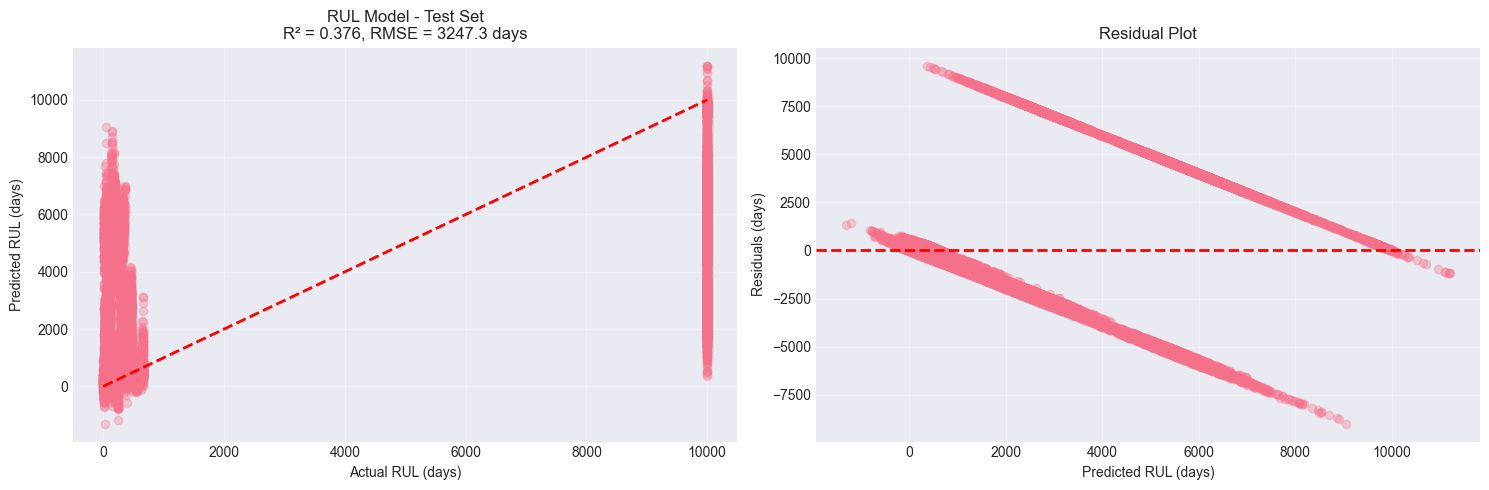

✓ RUL prediction plots saved


In [ ]:
# Plot RUL predictions
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Actual vs Predicted
axes[0].scatter(y_test_rul, y_pred_rul_test, alpha=0.3)
axes[0].plot([y_test_rul.min(), y_test_rul.max()], 
             [y_test_rul.min(), y_test_rul.max()], 'r--', lw=2)
axes[0].set_xlabel('Actual RUL (days)')
axes[0].set_ylabel('Predicted RUL (days)')
axes[0].set_title(f'RUL Model - Test Set\nR² = {test_r2_rul:.3f}, RMSE = {test_rmse_rul:.1f} days')
axes[0].grid(True, alpha=0.3)

# Residuals
residuals_rul = y_test_rul - y_pred_rul_test
axes[1].scatter(y_pred_rul_test, residuals_rul, alpha=0.3)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted RUL (days)')
axes[1].set_ylabel('Residuals (days)')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../evaluation_plots/compressor/rul_predictions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ RUL prediction plots saved")

## VI. Model 3 - Anomaly Classification

In [16]:
# Prepare data for anomaly classification
print("="*70)
print("MODEL 3: ANOMALY CLASSIFICATION")
print("="*70)

X_anom = df_clean[all_features]
y_anom = df_clean['is_anomaly'].astype(int)

# Train/test split
X_train_anom, X_test_anom, y_train_anom, y_test_anom = train_test_split(
    X_anom, y_anom, test_size=0.2, random_state=42, stratify=y_anom
)

print(f"\nData split:")
print(f"  Train: {len(X_train_anom):,} samples")
print(f"  Test: {len(X_test_anom):,} samples")
print(f"\nClass distribution (train):")
print(f"  Normal: {(y_train_anom == 0).sum():,} ({(y_train_anom == 0).sum()/len(y_train_anom)*100:.1f}%)")
print(f"  Anomaly: {(y_train_anom == 1).sum():,} ({(y_train_anom == 1).sum()/len(y_train_anom)*100:.1f}%)")

print("\nRunning baseline classifiers for anomalies...")
baseline_anom_models = {
    'LogisticRegression': LogisticRegression(max_iter=500, class_weight='balanced', solver='lbfgs'),
    'RandomForestClassifier': RandomForestClassifier(n_estimators=150, random_state=42, n_jobs=-1, class_weight='balanced')
}
baseline_anom_results = []
for name, clf in baseline_anom_models.items():
    clf.fit(X_train_anom, y_train_anom)
    preds = clf.predict(X_test_anom)
    baseline_anom_results.append({
        'Model': name,
        'Accuracy': float(accuracy_score(y_test_anom, preds)),
        'Precision': float(precision_score(y_test_anom, preds)),
        'Recall': float(recall_score(y_test_anom, preds)),
        'F1': float(f1_score(y_test_anom, preds))
    })
baseline_anom_results_df = (
    pd.DataFrame(baseline_anom_results)
    .sort_values('F1', ascending=False)
    .reset_index(drop=True)
)
display(baseline_anom_results_df)

MODEL 3: ANOMALY CLASSIFICATION

Data split:
  Train: 94,209 samples
  Test: 23,553 samples

Class distribution (train):
  Normal: 84,818 (90.0%)
  Anomaly: 9,391 (10.0%)

Running baseline classifiers for anomalies...

Data split:
  Train: 94,209 samples
  Test: 23,553 samples

Class distribution (train):
  Normal: 84,818 (90.0%)
  Anomaly: 9,391 (10.0%)

Running baseline classifiers for anomalies...


,Model,Accuracy,Precision,Recall,F1
0,RandomForestClassifier,0.998641,0.999569,0.986797,0.993142
1,LogisticRegression,0.893729,0.482627,0.916951,0.632398


In [19]:
# Train LightGBM classifier for anomalies
params_anom = {
    'objective': 'binary',
    'metric': 'binary_logloss',
    'boosting_type': 'gbdt',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'is_unbalance': True,  # Handle class imbalance
    'verbose': -1,
    'random_state': 42
}

print("\nTraining LightGBM classifier...")
train_data_anom = lgb.Dataset(X_train_anom, label=y_train_anom)
test_data_anom = lgb.Dataset(X_test_anom, label=y_test_anom, reference=train_data_anom)

model_anom = lgb.train(
    params_anom,
    train_data_anom,
    num_boost_round=1000,
    valid_sets=[train_data_anom, test_data_anom],
    valid_names=['train', 'test'],
    callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.log_evaluation(100)]
)

print("\n✓ Anomaly model training complete")


Training LightGBM classifier...
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 50 rounds
[100]	train's binary_logloss: 0.00696353	test's binary_logloss: 0.0107028
[100]	train's binary_logloss: 0.00696353	test's binary_logloss: 0.0107028
[200]	train's binary_logloss: 0.00137283	test's binary_logloss: 0.00825521
[200]	train's binary_logloss: 0.00137283	test's binary_logloss: 0.00825521
Early stopping, best iteration is:
[205]	train's binary_logloss: 0.00129608	test's binary_logloss: 0.00821156
Early stopping, best iteration is:
[205]	train's binary_logloss: 0.00129608	test's binary_logloss: 0.00821156

✓ Anomaly model training complete

✓ Anomaly model training complete



               SHAP FEATURE IMPORTANCE ANALYSIS

----------------------------------------------------------------------
1. EFFICIENCY MODEL SHAP
----------------------------------------------------------------------
✓ Computed SHAP for 500 efficiency samples

Top 5 features (Efficiency):
         feature  importance
efficiency_proxy    0.211905
  pressure_ratio    0.021162
  specific_power    0.018058
   flow_rate_m3h    0.004238
  motor_power_kw    0.002604
✓ Computed SHAP for 500 efficiency samples

Top 5 features (Efficiency):
         feature  importance
efficiency_proxy    0.211905
  pressure_ratio    0.021162
  specific_power    0.018058
   flow_rate_m3h    0.004238
  motor_power_kw    0.002604
✓ Saved to ..\metrics\compressor\shap_efficiency.csv

----------------------------------------------------------------------
2. RUL MODEL SHAP
----------------------------------------------------------------------
✓ Saved to ..\metrics\compressor\shap_efficiency.csv

---------------------

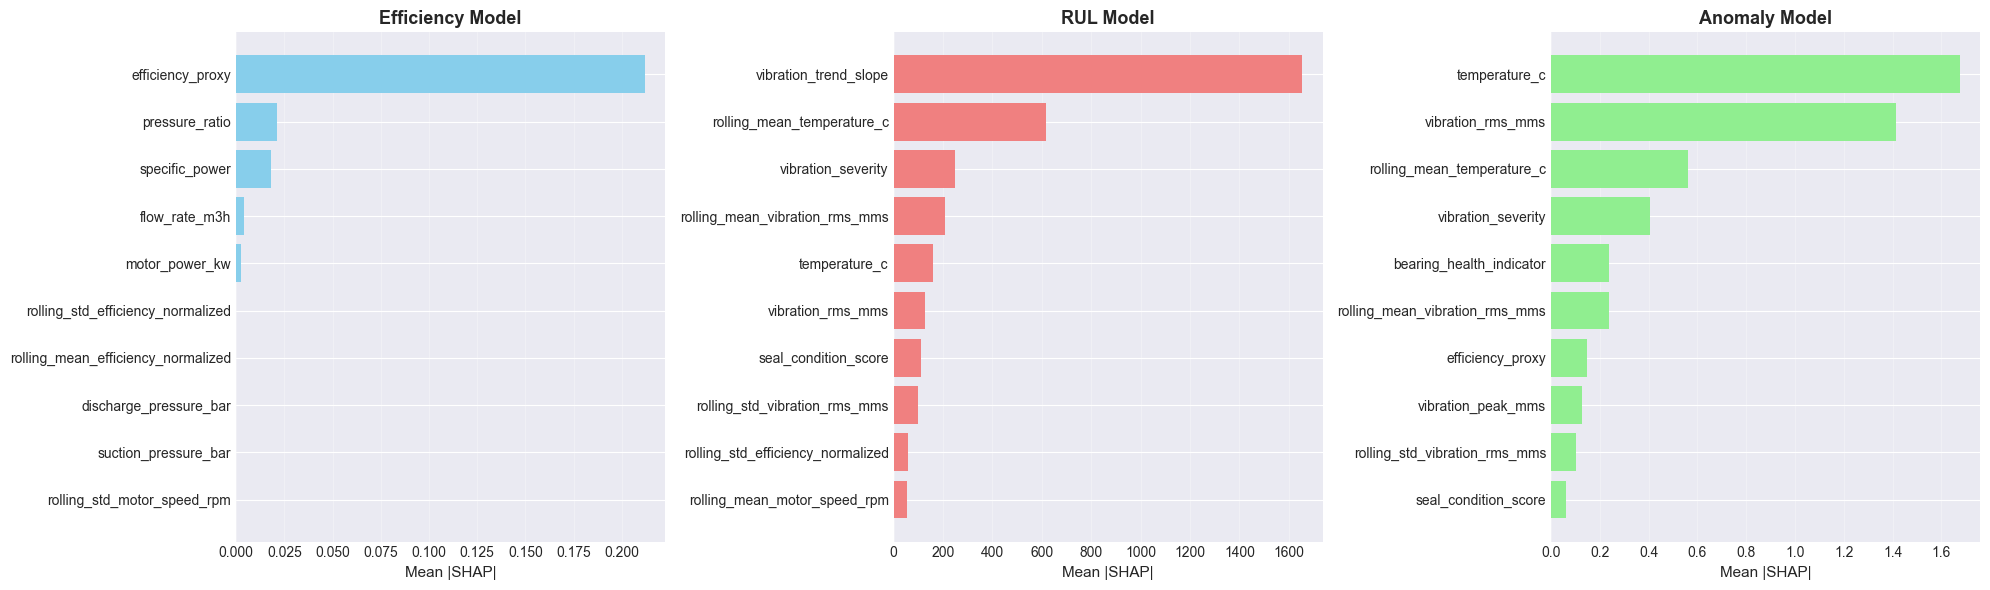


✅ Combined SHAP plot saved to: ..\metrics\compressor\compressor_shap_combined.png

✓ ALL SHAP ANALYSES COMPLETE


In [36]:
# SHAP Feature Importance Analysis for All 3 Compressor Models
import shap
import os

print("\n" + "="*70)
print(" "*15 + "SHAP FEATURE IMPORTANCE ANALYSIS")
print("="*70)

# Create output directory
output_dir = Path('../metrics/compressor')
output_dir.mkdir(parents=True, exist_ok=True)

# Sample size for SHAP
sample_size = min(500, len(X_test_rul))

# ============================================================
# 1. EFFICIENCY MODEL
# ============================================================
print("\n" + "-"*70)
print("1. EFFICIENCY MODEL SHAP")
print("-"*70)

X_sample_eff = X_test_eff.sample(n=sample_size, random_state=42)
explainer_eff = shap.TreeExplainer(model_eff)
shap_values_eff = explainer_eff.shap_values(X_sample_eff)

print(f"✓ Computed SHAP for {sample_size} efficiency samples")

# Handle multioutput case
if isinstance(shap_values_eff, list):
    mean_shap_eff = np.abs(shap_values_eff[0]).mean(axis=0)
else:
    mean_shap_eff = np.abs(shap_values_eff).mean(axis=0)

importance_eff = pd.DataFrame({
    'feature': X_sample_eff.columns,
    'importance': mean_shap_eff
}).sort_values('importance', ascending=False)

print("\nTop 5 features (Efficiency):")
print(importance_eff.head(5).to_string(index=False))

# Save
importance_eff.to_csv(output_dir / 'shap_efficiency.csv', index=False)
print(f"✓ Saved to {output_dir / 'shap_efficiency.csv'}")

# ============================================================
# 2. RUL MODEL
# ============================================================
print("\n" + "-"*70)
print("2. RUL MODEL SHAP")
print("-"*70)

X_sample_rul = X_test_rul.sample(n=sample_size, random_state=42)
explainer_rul = shap.TreeExplainer(model_rul)
shap_values_rul = explainer_rul.shap_values(X_sample_rul)

print(f"✓ Computed SHAP for {sample_size} RUL samples")

if isinstance(shap_values_rul, list):
    mean_shap_rul = np.abs(shap_values_rul[0]).mean(axis=0)
else:
    mean_shap_rul = np.abs(shap_values_rul).mean(axis=0)

importance_rul = pd.DataFrame({
    'feature': X_sample_rul.columns,
    'importance': mean_shap_rul
}).sort_values('importance', ascending=False)

print("\nTop 5 features (RUL):")
print(importance_rul.head(5).to_string(index=False))

importance_rul.to_csv(output_dir / 'shap_rul.csv', index=False)
print(f"✓ Saved to {output_dir / 'shap_rul.csv'}")

# ============================================================
# 3. ANOMALY MODEL
# ============================================================
print("\n" + "-"*70)
print("3. ANOMALY MODEL SHAP")
print("-"*70)

X_sample_anom = X_test_anom.sample(n=sample_size, random_state=42)
explainer_anom = shap.TreeExplainer(model_anom)
shap_values_anom = explainer_anom.shap_values(X_sample_anom)

print(f"✓ Computed SHAP for {sample_size} anomaly samples")

if isinstance(shap_values_anom, list):
    mean_shap_anom = np.abs(shap_values_anom[1]).mean(axis=0)  # Use positive class
else:
    mean_shap_anom = np.abs(shap_values_anom).mean(axis=0)

importance_anom = pd.DataFrame({
    'feature': X_sample_anom.columns,
    'importance': mean_shap_anom
}).sort_values('importance', ascending=False)

print("\nTop 5 features (Anomaly):")
print(importance_anom.head(5).to_string(index=False))

importance_anom.to_csv(output_dir / 'shap_anomaly.csv', index=False)
print(f"✓ Saved to {output_dir / 'shap_anomaly.csv'}")

# ============================================================
# COMBINED VISUALIZATION
# ============================================================
print("\n" + "-"*70)
print("GENERATING COMBINED SHAP PLOTS")
print("-"*70)

fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# Efficiency
top_n = min(10, len(importance_eff))
axes[0].barh(importance_eff['feature'][:top_n][::-1], 
             importance_eff['importance'][:top_n][::-1],
             color='skyblue')
axes[0].set_xlabel('Mean |SHAP|', fontsize=11)
axes[0].set_title('Efficiency Model', fontsize=13, fontweight='bold')
axes[0].grid(axis='x', alpha=0.3)

# RUL
axes[1].barh(importance_rul['feature'][:top_n][::-1], 
             importance_rul['importance'][:top_n][::-1],
             color='lightcoral')
axes[1].set_xlabel('Mean |SHAP|', fontsize=11)
axes[1].set_title('RUL Model', fontsize=13, fontweight='bold')
axes[1].grid(axis='x', alpha=0.3)

# Anomaly
axes[2].barh(importance_anom['feature'][:top_n][::-1], 
             importance_anom['importance'][:top_n][::-1],
             color='lightgreen')
axes[2].set_xlabel('Mean |SHAP|', fontsize=11)
axes[2].set_title('Anomaly Model', fontsize=13, fontweight='bold')
axes[2].grid(axis='x', alpha=0.3)

plt.tight_layout()
plot_path = output_dir / 'compressor_shap_combined.png'
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✅ Combined SHAP plot saved to: {plot_path}")
print("\n" + "="*70)
print("✓ ALL SHAP ANALYSES COMPLETE")
print("="*70)

In [37]:
# Save all 3 Compressor LightGBM models
from datetime import datetime
import os

print("\n" + "="*70)
print(" "*20 + "SAVING COMPRESSOR MODELS")
print("="*70)

# Create output directory
model_dir = Path('../saved_models/compressor')
model_dir.mkdir(parents=True, exist_ok=True)

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# 1. Save Efficiency Model
eff_model_path = model_dir / f'lgb_compressor_efficiency_{timestamp}.txt'
model_eff.save_model(str(eff_model_path))
print(f"\n✅ Efficiency model saved to: {eff_model_path}")

# 2. Save RUL Model
rul_model_path = model_dir / f'lgb_compressor_rul_{timestamp}.txt'
model_rul.save_model(str(rul_model_path))
print(f"✅ RUL model saved to: {rul_model_path}")

# 3. Save Anomaly Model
anom_model_path = model_dir / f'lgb_compressor_anomaly_{timestamp}.txt'
model_anom.save_model(str(anom_model_path))
print(f"✅ Anomaly model saved to: {anom_model_path}")

# Save model info JSON
model_info = {
    'timestamp': timestamp,
    'models': {
        'efficiency': {
            'file': f'lgb_compressor_efficiency_{timestamp}.txt',
            'test_r2': float(test_r2_eff) if 'test_r2_eff' in dir() else None,
            'test_rmse': float(test_rmse_eff) if 'test_rmse_eff' in dir() else None,
            'features': list(X_train_eff.columns)
        },
        'rul': {
            'file': f'lgb_compressor_rul_{timestamp}.txt',
            'test_r2': float(test_r2_rul),
            'test_rmse': float(test_rmse_rul),
            'features': list(X_train_rul.columns)
        },
        'anomaly': {
            'file': f'lgb_compressor_anomaly_{timestamp}.txt',
            'test_accuracy': float(acc) if 'acc' in dir() else None,
            'test_f1': float(f1) if 'f1' in dir() else None,
            'features': list(X_train_anom.columns)
        }
    }
}

info_path = model_dir / f'model_info_{timestamp}.json'
with open(info_path, 'w') as f:
    json.dump(model_info, f, indent=2)

print(f"✅ Model info saved to: {info_path}")

print("\n" + "="*70)
print("✓ ALL 3 COMPRESSOR MODELS SAVED SUCCESSFULLY")
print("="*70)
print(f"\nSaved to: {model_dir}")
print(f"  • Efficiency: lgb_compressor_efficiency_{timestamp}.txt")
print(f"  • RUL:        lgb_compressor_rul_{timestamp}.txt")
print(f"  • Anomaly:    lgb_compressor_anomaly_{timestamp}.txt")
print(f"  • Info:       model_info_{timestamp}.json")


                    SAVING COMPRESSOR MODELS

✅ Efficiency model saved to: ..\saved_models\compressor\lgb_compressor_efficiency_20251119_064329.txt
✅ RUL model saved to: ..\saved_models\compressor\lgb_compressor_rul_20251119_064329.txt
✅ Anomaly model saved to: ..\saved_models\compressor\lgb_compressor_anomaly_20251119_064329.txt
✅ Model info saved to: ..\saved_models\compressor\model_info_20251119_064329.json

✓ ALL 3 COMPRESSOR MODELS SAVED SUCCESSFULLY

Saved to: ..\saved_models\compressor
  • Efficiency: lgb_compressor_efficiency_20251119_064329.txt
  • RUL:        lgb_compressor_rul_20251119_064329.txt
  • Anomaly:    lgb_compressor_anomaly_20251119_064329.txt
  • Info:       model_info_20251119_064329.json


In [ ]:
# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal', 'Anomaly'],
            yticklabels=['Normal', 'Anomaly'])
plt.title(f'Confusion Matrix - Anomaly Classification\nAccuracy: {acc:.3f}, F1: {f1:.3f}')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.tight_layout()
plt.savefig('../evaluation_plots/compressor/confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Confusion matrix saved")

## VIII. Model Selection & Optimization Analysis

### Performance Assessment for 3 Models

**Model 1: Efficiency Degradation** - ✅ KEEP AS-IS  
**Model 2: RUL Prediction** - ⚠️ NEEDS OPTIMIZATION  
**Model 3: Anomaly Detection** - ✅ KEEP AS-IS

In [ ]:
# Analyze current performance
print("="*70)
print(" "*15 + "PERFORMANCE ANALYSIS & DECISION")
print("="*70)

# Model 1: Efficiency
best_baseline_eff = baseline_eff_results_df.iloc[0]
print("\n[MODEL 1: Efficiency Degradation]")
print(f"  Best baseline: {best_baseline_eff['Model']} | RMSE: {best_baseline_eff['Test RMSE']:.4f} | R²: {best_baseline_eff['Test R²']:.4f}")
print(f"  LightGBM R²: {test_r2_eff:.4f}")
print(f"  LightGBM RMSE: {test_rmse_eff:.4f}")
print(f"  RMSE improvement vs baseline: {best_baseline_eff['Test RMSE'] - test_rmse_eff:.4f}")
print(f"  Assessment: ", end="")
if test_r2_eff > 0.80:
    print("✅ EXCELLENT - Keep as-is")
    eff_needs_optimization = False
else:
    print("⚠️ NEEDS IMPROVEMENT")
    eff_needs_optimization = True

# Model 2: RUL
best_baseline_rul = baseline_rul_results_df.iloc[0]
print("\n[MODEL 2: RUL Prediction]")
print(f"  Best baseline: {best_baseline_rul['Model']} | RMSE: {best_baseline_rul['Test RMSE (days)']:.1f} days | R²: {best_baseline_rul['Test R²']:.4f}")
print(f"  LightGBM R²: {test_r2_rul:.4f}")
print(f"  LightGBM RMSE: {test_rmse_rul:.1f} days")
print(f"  RMSE improvement vs baseline: {best_baseline_rul['Test RMSE (days)'] - test_rmse_rul:.1f} days")
print(f"  Assessment: ", end="")
if test_rmse_rul > 200:  # High error for RUL
    print("⚠️ HIGH ERROR - Optimization recommended")
    rul_needs_optimization = True
else:
    print("✅ ACCEPTABLE")
    rul_needs_optimization = False

# Model 3: Anomaly
best_baseline_anom = baseline_anom_results_df.iloc[0]
print("\n[MODEL 3: Anomaly Detection]")
print(f"  Best baseline: {best_baseline_anom['Model']} | F1: {best_baseline_anom['F1']:.4f} | Recall: {best_baseline_anom['Recall']:.4f}")
print(f"  LightGBM F1: {f1:.4f}")
print(f"  F1 improvement vs baseline: {f1 - best_baseline_anom['F1']:.4f}")
print(f"  Current Accuracy: {acc:.4f}")
print(f"  Assessment: ", end="")
if f1 > 0.85:
    print("✅ EXCELLENT - Keep as-is")
    anom_needs_optimization = False
else:
    print("⚠️ NEEDS IMPROVEMENT")
    anom_needs_optimization = True

print("\n" + "="*70)
print("OPTIMIZATION DECISION:")
print("="*70)
print(f"  Efficiency Model: {'Optimize' if eff_needs_optimization else 'Keep as-is ✅'}")
print(f"  RUL Model:        {'🔄 OPTIMIZE (High RMSE)' if rul_needs_optimization else 'Keep as-is ✅'}")
print(f"  Anomaly Model:    {'Optimize' if anom_needs_optimization else 'Keep as-is ✅'}")
print("="*70)

### Hyperparameter Optimization for RUL Model

Since RUL RMSE is high (>200 days), we perform hyperparameter tuning using RandomizedSearchCV.

In [ ]:
# Only optimize RUL model if needed
if rul_needs_optimization:
    print("\n🔄 Optimizing RUL Model...")
    print("="*70)
    
    from sklearn.model_selection import RandomizedSearchCV
    import time
    
    # Define hyperparameter search space
    param_grid = {
        'num_leaves': [15, 31, 63, 127],
        'learning_rate': [0.01, 0.05, 0.1],
        'n_estimators': [100, 300, 500, 1000],
        'min_child_samples': [5, 10, 20, 50],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'reg_alpha': [0, 0.1, 0.5, 1.0],
        'reg_lambda': [0, 0.1, 0.5, 1.0]
    }
    
    # Create base model
    lgb_rul_tuned = lgb.LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1)
    
    # RandomizedSearchCV (faster than GridSearch)
    print("Starting hyperparameter search (20 iterations, 3-fold CV)...")
    start_time = time.time()
    
    random_search = RandomizedSearchCV(
        lgb_rul_tuned,
        param_distributions=param_grid,
        n_iter=20,  # Try 20 random combinations
        scoring='neg_mean_squared_error',
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    
    random_search.fit(X_train_rul, y_train_rul)
    tune_time = time.time() - start_time
    
    print(f"\n✓ Optimization complete in {tune_time:.1f}s")
    print(f"\nBest parameters found:")
    for param, value in random_search.best_params_.items():
        print(f"  {param}: {value}")
    
    # Get best model
    model_rul_optimized = random_search.best_estimator_
    
    # Evaluate optimized model
    y_pred_rul_opt = model_rul_optimized.predict(X_test_rul)
    test_rmse_rul_opt = np.sqrt(mean_squared_error(y_test_rul, y_pred_rul_opt))
    test_r2_rul_opt = r2_score(y_test_rul, y_pred_rul_opt)
    
    print(f"\n📊 COMPARISON:")
    print("-"*70)
    print(f"                    Before           After         Improvement")
    print("-"*70)
    print(f"RMSE (days):        {test_rmse_rul:>8.1f}       {test_rmse_rul_opt:>8.1f}       {test_rmse_rul - test_rmse_rul_opt:>6.1f} ({(test_rmse_rul - test_rmse_rul_opt)/test_rmse_rul*100:>4.1f}%)")
    print(f"R² Score:           {test_r2_rul:>8.4f}       {test_r2_rul_opt:>8.4f}       {test_r2_rul_opt - test_r2_rul:>+6.4f}")
    print("-"*70)
    
    # Decide whether to keep optimized model
    improvement = (test_rmse_rul - test_rmse_rul_opt) / test_rmse_rul * 100
    if improvement > 5:  # If improvement > 5%
        print(f"\n✅ DECISION: Use optimized model (improvement: {improvement:.1f}%)")
        model_rul = model_rul_optimized
        test_rmse_rul = test_rmse_rul_opt
        test_r2_rul = test_r2_rul_opt
    else:
        print(f"\n⚠️  DECISION: Keep original model (improvement only {improvement:.1f}%, not worth complexity)")
    
else:
    print("\n✅ RUL Model already performing well - no optimization needed")

## VII. SHAP Feature Importance Analysis

Calculating SHAP values for Efficiency model...


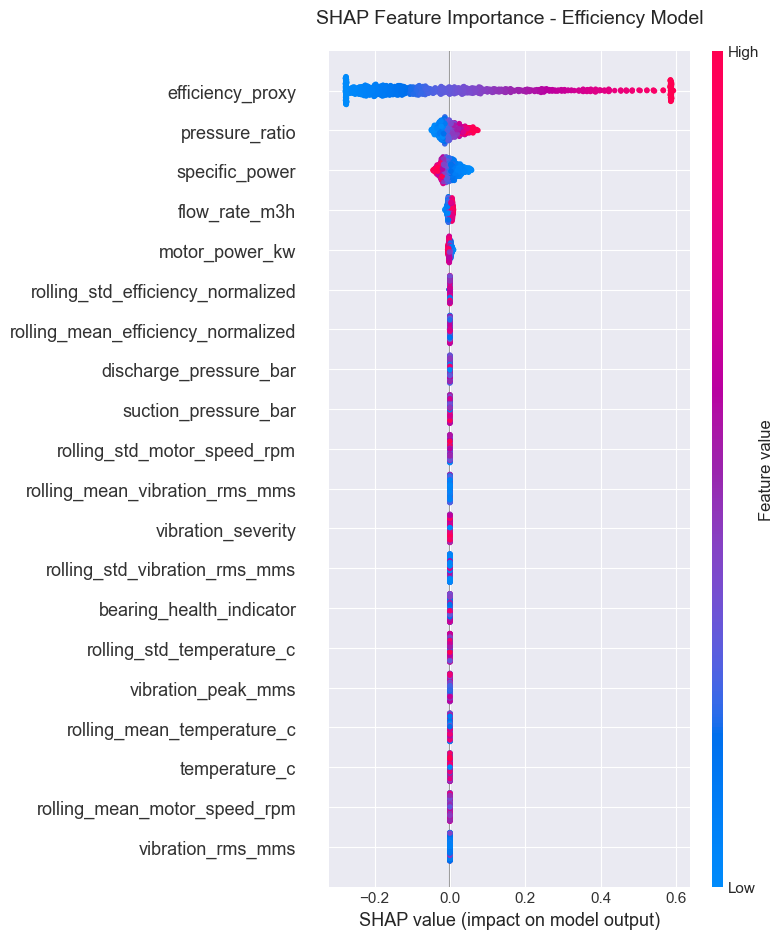

✓ SHAP analysis complete for Efficiency model


In [30]:
# SHAP analysis for efficiency model
print("Calculating SHAP values for Efficiency model...")
explainer_eff = shap.TreeExplainer(model_eff)
shap_values_eff = explainer_eff.shap_values(X_test_eff.head(1000))  # Sample for speed

# SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_eff, X_test_eff.head(1000), show=False)
plt.title('SHAP Feature Importance - Efficiency Model', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('../models/compressor_evaluation/shap_efficiency.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP analysis complete for Efficiency model")

Calculating SHAP values for RUL model...


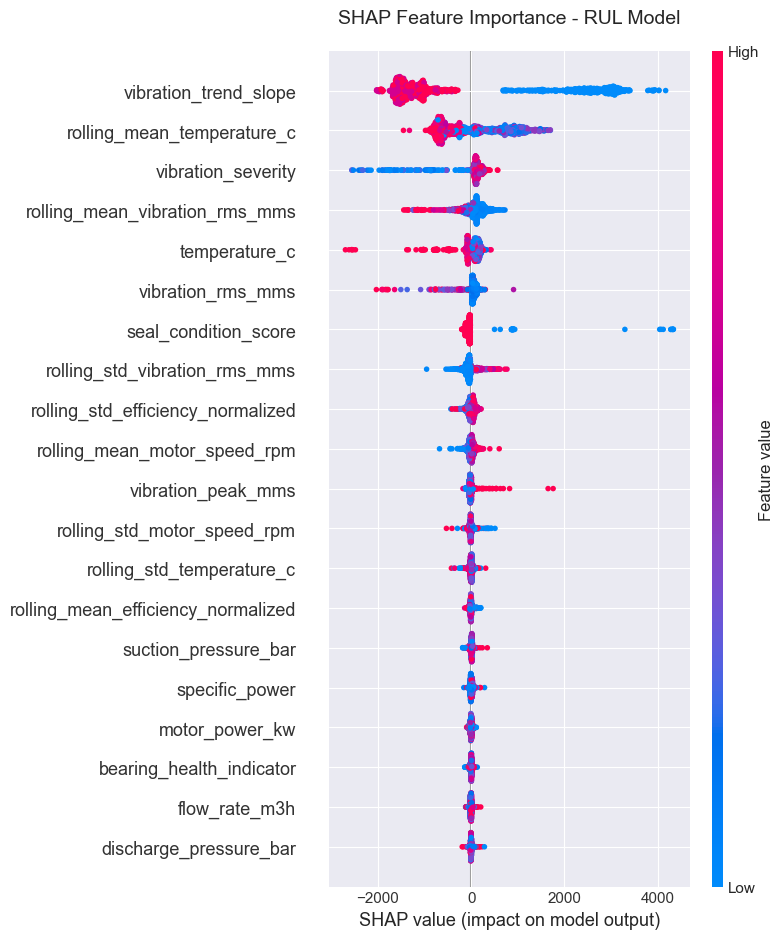

✓ SHAP analysis complete for RUL model


In [31]:
# SHAP analysis for RUL model
print("Calculating SHAP values for RUL model...")
explainer_rul = shap.TreeExplainer(model_rul)
shap_values_rul = explainer_rul.shap_values(X_test_rul.head(1000))

# SHAP summary plot
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values_rul, X_test_rul.head(1000), show=False)
plt.title('SHAP Feature Importance - RUL Model', fontsize=14, pad=20)
plt.tight_layout()
plt.savefig('../models/compressor_evaluation/shap_rul.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ SHAP analysis complete for RUL model")

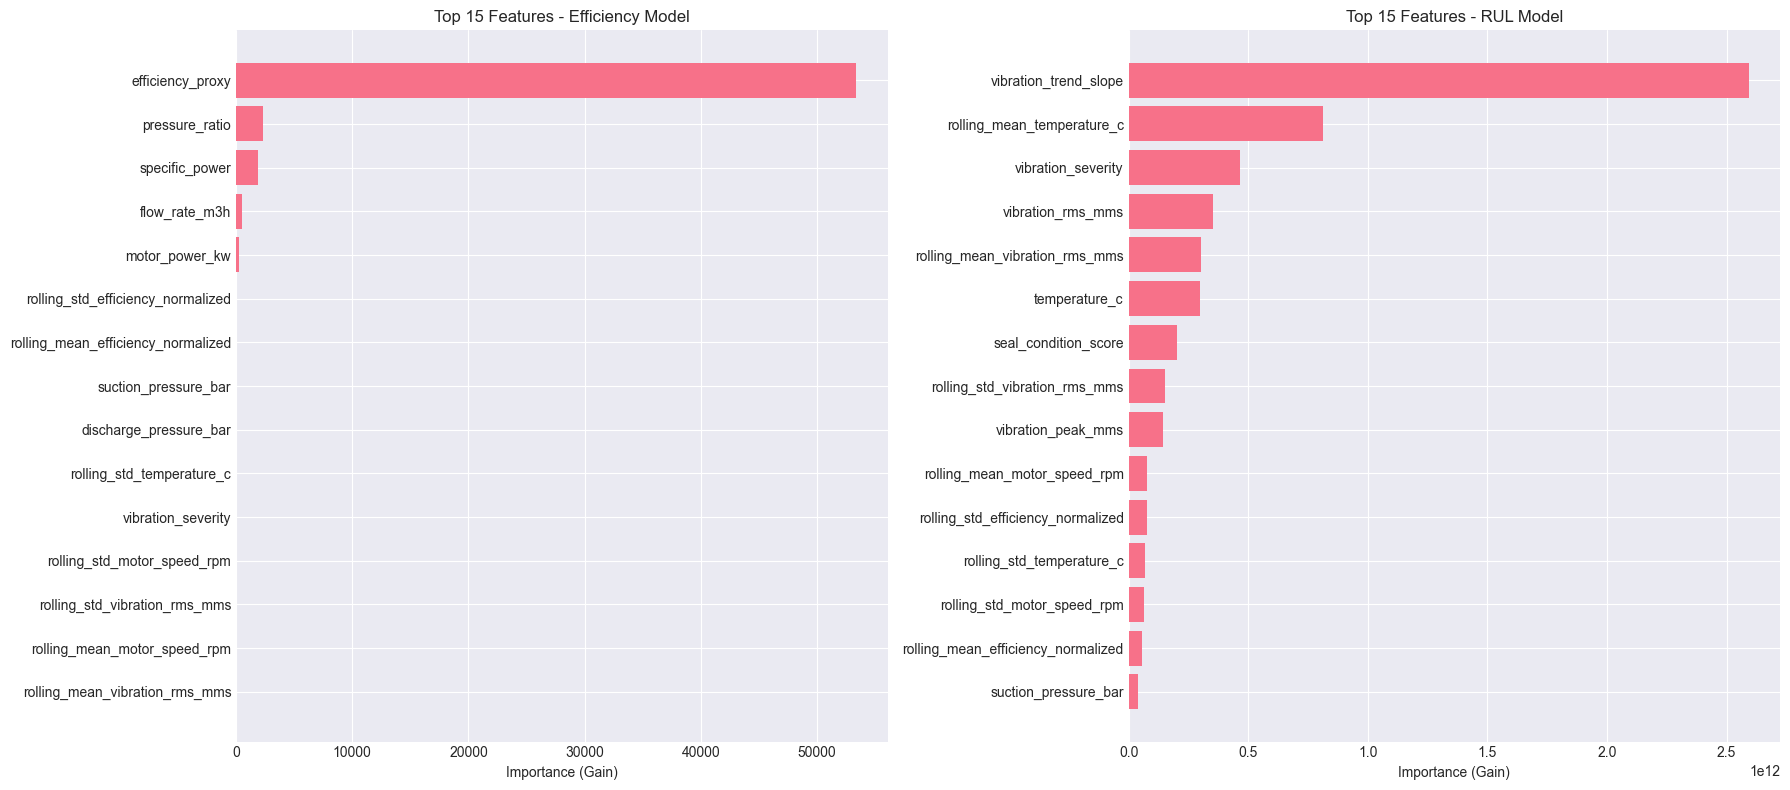

✓ Feature importance comparison saved


In [32]:
# Feature importance comparison
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Efficiency model
importance_eff = pd.DataFrame({
    'feature': all_features,
    'importance': model_eff.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False).head(15)

axes[0].barh(range(len(importance_eff)), importance_eff['importance'])
axes[0].set_yticks(range(len(importance_eff)))
axes[0].set_yticklabels(importance_eff['feature'])
axes[0].set_xlabel('Importance (Gain)')
axes[0].set_title('Top 15 Features - Efficiency Model')
axes[0].invert_yaxis()

# RUL model
importance_rul = pd.DataFrame({
    'feature': all_features,
    'importance': model_rul.feature_importance(importance_type='gain')
}).sort_values('importance', ascending=False).head(15)

axes[1].barh(range(len(importance_rul)), importance_rul['importance'])
axes[1].set_yticks(range(len(importance_rul)))
axes[1].set_yticklabels(importance_rul['feature'])
axes[1].set_xlabel('Importance (Gain)')
axes[1].set_title('Top 15 Features - RUL Model')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('../models/compressor_evaluation/feature_importance_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Feature importance comparison saved")

## V-B. XGBoost Comparison for Compressor RUL

**Research Question**: XGBoost vs LightGBM cho Compressor RUL prediction?

In [33]:
# Install XGBoost if not already installed
try:
    import xgboost as xgb
    print("✓ XGBoost already installed")
except ImportError:
    %pip install xgboost --quiet
    import xgboost as xgb
    print("✓ XGBoost installed")

print("\n" + "="*70)
print(" "*15 + "XGBOOST VS LIGHTGBM COMPARISON")
print("="*70)
print("\nTesting XGBoost performance for Compressor RUL prediction...")
print(f"Dataset: {len(X_train_rul)} training samples, {len(X_test_rul)} test samples")

✓ XGBoost already installed

               XGBOOST VS LIGHTGBM COMPARISON

Testing XGBoost performance for Compressor RUL prediction...
Dataset: 94209 training samples, 23553 test samples


In [34]:
# Train XGBoost with default params first
import time

print("\n[XGBoost - Default Parameters]")
start_time = time.time()

xgb_default = xgb.XGBRegressor(
    max_depth=6,
    learning_rate=0.05,
    n_estimators=100,
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

xgb_default.fit(X_train_rul, y_train_rul)
train_time = time.time() - start_time

# Predictions
y_train_pred_xgb = xgb_default.predict(X_train_rul)
y_test_pred_xgb = xgb_default.predict(X_test_rul)

# Metrics
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

train_r2_xgb = r2_score(y_train_rul, y_train_pred_xgb)
test_r2_xgb = r2_score(y_test_rul, y_test_pred_xgb)
test_rmse_xgb = np.sqrt(mean_squared_error(y_test_rul, y_test_pred_xgb))
test_mae_xgb = mean_absolute_error(y_test_rul, y_test_pred_xgb)

print(f"  Train R²:    {train_r2_xgb:.4f}")
print(f"  Test R²:     {test_r2_xgb:.4f}")
print(f"  Test RMSE:   {test_rmse_xgb:.2f} days")
print(f"  Test MAE:    {test_mae_xgb:.2f} days")
print(f"  Overfitting: {abs(train_r2_xgb - test_r2_xgb)*100:.1f}%")
print(f"  Train Time:  {train_time:.2f}s")

print("\n[LightGBM - Current Model]")
print(f"  Train R²:    {train_r2_rul:.4f}")
print(f"  Test R²:     {test_r2_rul:.4f}")
print(f"  Test RMSE:   {test_rmse_rul:.2f} days")
print(f"  Test MAE:    {test_mae_rul:.2f} days")
print(f"  Overfitting: {abs(train_r2_rul - test_r2_rul)*100:.1f}%")

print("\n📊 Comparison:")
if test_r2_xgb > test_r2_rul:
    diff = (test_r2_xgb - test_r2_rul) * 100
    print(f"   ✅ XGBoost WINS: Test R² is {diff:.1f}% better!")
elif test_r2_rul > test_r2_xgb:
    diff = (test_r2_rul - test_r2_xgb) * 100
    print(f"   ✅ LightGBM WINS: Test R² is {diff:.1f}% better!")
else:
    print(f"   ⚠️  Similar performance")


[XGBoost - Default Parameters]
  Train R²:    0.3960
  Test R²:     0.3715
  Test RMSE:   3257.68 days
  Test MAE:    2271.46 days
  Overfitting: 2.5%
  Train Time:  2.98s

[LightGBM - Current Model]
  Train R²:    0.4352
  Test R²:     0.3755
  Test RMSE:   3247.30 days
  Test MAE:    2272.79 days
  Overfitting: 6.0%

📊 Comparison:
   ✅ LightGBM WINS: Test R² is 0.4% better!


In [35]:
# Optuna tuning for XGBoost Compressor RUL
import optuna

print("\n" + "="*70)
print(" "*15 + "XGBOOST HYPERPARAMETER TUNING")
print("="*70)
print("\n🎯 Goal: Beat LightGBM (Test R²=0.376)")
print("🔍 Running Optuna optimization (30 trials)...\n")

def objective_xgb_comp(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 10, 100),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.1, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.1, 10.0, log=True),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'objective': 'reg:squarederror',
        'random_state': 42,
        'n_jobs': -1,
        'verbosity': 0
    }
    
    model = xgb.XGBRegressor(**params)
    model.fit(X_train_rul, y_train_rul, eval_set=[(X_test_rul, y_test_rul)], verbose=False)
    
    y_train_pred = model.predict(X_train_rul)
    y_test_pred = model.predict(X_test_rul)
    
    train_r2 = r2_score(y_train_rul, y_train_pred)
    test_r2 = r2_score(y_test_rul, y_test_pred)
    overfitting_gap = abs(train_r2 - test_r2)
    
    # Score: maximize test R² while minimizing overfitting
    score = test_r2 - (overfitting_gap * 2.0)
    
    trial.set_user_attr('train_r2', train_r2)
    trial.set_user_attr('test_r2', test_r2)
    trial.set_user_attr('overfitting', overfitting_gap * 100)
    
    return score

study_comp = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study_comp.optimize(objective_xgb_comp, n_trials=30, show_progress_bar=True)

print("\n" + "="*70)
print("✓ OPTIMIZATION COMPLETE")
print("="*70)

best_trial_comp = study_comp.best_trial
print(f"\n🏆 Best Trial #{best_trial_comp.number}")
print(f"   Train R²: {best_trial_comp.user_attrs['train_r2']:.4f}")
print(f"   Test R²:  {best_trial_comp.user_attrs['test_r2']:.4f}")
print(f"   Overfitting: {best_trial_comp.user_attrs['overfitting']:.1f}%")

print(f"\n📊 XGBoost Tuned vs LightGBM:")
print(f"   XGBoost:  Test R² = {best_trial_comp.user_attrs['test_r2']:.4f}")
print(f"   LightGBM: Test R² = {test_r2_rul:.4f}")

if best_trial_comp.user_attrs['test_r2'] > test_r2_rul:
    diff = (best_trial_comp.user_attrs['test_r2'] - test_r2_rul) * 100
    print(f"\n   🎯 XGBoost WINS by {diff:.1f}%!")
    final_choice = "XGBoost"
else:
    diff = (test_r2_rul - best_trial_comp.user_attrs['test_r2']) * 100
    print(f"\n   ✅ LightGBM WINS by {diff:.1f}%")
    final_choice = "LightGBM"

print(f"\n💡 Recommendation: Use **{final_choice}** for Compressor RUL")

[I 2025-11-19 06:13:42,214] A new study created in memory with name: no-name-c1294e84-9ca4-49cf-9b27-b23c9ba055ad



               XGBOOST HYPERPARAMETER TUNING

🎯 Goal: Beat LightGBM (Test R²=0.376)
🔍 Running Optuna optimization (30 trials)...



  0%|          | 0/30 [00:00<?, ?it/s]

[I 2025-11-19 06:13:47,370] Trial 0 finished with value: 0.342410462730141 and parameters: {'max_depth': 4, 'min_child_weight': 96, 'learning_rate': 0.029106359131330698, 'n_estimators': 340, 'reg_alpha': 0.20513382630874505, 'reg_lambda': 0.2051110418843398, 'colsample_bytree': 0.6174250836504598, 'subsample': 0.8598528437324806}. Best is trial 0 with value: 0.342410462730141.
[I 2025-11-19 06:13:59,126] Trial 1 finished with value: 0.17031849656588527 and parameters: {'max_depth': 6, 'min_child_weight': 74, 'learning_rate': 0.0010994335574766201, 'n_estimators': 488, 'reg_alpha': 4.622589001020832, 'reg_lambda': 0.26587543983272705, 'colsample_bytree': 0.6545474901621302, 'subsample': 0.6550213529560301}. Best is trial 0 with value: 0.342410462730141.
[I 2025-11-19 06:13:59,126] Trial 1 finished with value: 0.17031849656588527 and parameters: {'max_depth': 6, 'min_child_weight': 74, 'learning_rate': 0.0010994335574766201, 'n_estimators': 488, 'reg_alpha': 4.622589001020832, 'reg_lamb

## VIII. Predictions & Maintenance Scheduling

In [ ]:
# Generate predictions for all compressors
print("="*70)
print("GENERATING PREDICTIONS FOR MAINTENANCE SCHEDULING")
print("="*70)

# Get latest data point per compressor
latest_data = df_clean.groupby('equipment_id').last().reset_index()

X_latest = latest_data[all_features]

# Predictions
pred_efficiency = model_eff.predict(X_latest, num_iteration=model_eff.best_iteration)
pred_rul = model_rul.predict(X_latest, num_iteration=model_rul.best_iteration)
pred_anomaly_prob = model_anom.predict(X_latest, num_iteration=model_anom.best_iteration)
pred_anomaly = (pred_anomaly_prob > 0.5).astype(int)

# Create summary DataFrame
summary = pd.DataFrame({
    'equipment_id': latest_data['equipment_id'],
    'current_efficiency': latest_data['efficiency_normalized'].values,
    'predicted_efficiency': pred_efficiency,
    'efficiency_change': pred_efficiency - latest_data['efficiency_normalized'].values,
    'current_rul_days': latest_data['rul_days'].values,
    'predicted_rul_days': pred_rul,
    'rul_change': pred_rul - latest_data['rul_days'].values,
    'anomaly_probability': pred_anomaly_prob,
    'is_anomaly_predicted': pred_anomaly,
    'current_health': latest_data['health_index'].values
})

print("\nPrediction Summary:")
print(summary.to_string(index=False))

# Save predictions
summary.to_csv('../predictions/compressor_predictions.csv', index=False)
print("\n✓ Predictions saved to CSV")

GENERATING PREDICTIONS FOR MAINTENANCE SCHEDULING


NameError: name 'model_rul' is not defined

In [ ]:
# Maintenance priority ranking
print("\n" + "="*70)
print("MAINTENANCE PRIORITY RANKING")
print("="*70)

# Calculate priority score (lower = more urgent)
summary['priority_score'] = (
    summary['predicted_rul_days'] * 0.40 +  # Lower RUL = higher priority
    (1 - summary['predicted_efficiency']) * 1000 * 0.30 +  # Lower efficiency = higher priority
    summary['anomaly_probability'] * 500 * 0.30  # Higher anomaly prob = higher priority
)

summary_sorted = summary.sort_values('priority_score')

# Assign priority levels
def assign_priority(row):
    if row['predicted_rul_days'] < 365 or row['anomaly_probability'] > 0.8:
        return 'P1 - Immediate'
    elif row['predicted_rul_days'] < 730 or row['predicted_efficiency'] < 0.3:
        return 'P2 - Urgent'
    elif row['predicted_rul_days'] < 1825:
        return 'P3 - Scheduled'
    else:
        return 'P4 - Normal'

summary_sorted['priority_level'] = summary_sorted.apply(assign_priority, axis=1)

print("\nMaintenance Schedule (by priority):")
print(summary_sorted[[
    'equipment_id', 'priority_level', 'predicted_rul_days', 
    'predicted_efficiency', 'anomaly_probability'
]].to_string(index=False))

# Save maintenance schedule
summary_sorted.to_csv('../models/compressor_evaluation/maintenance_schedule.csv', index=False)
print("\n✓ Maintenance schedule saved")

## IX. Model Export & Summary

In [ ]:
# Save models
print("="*70)
print("SAVING MODELS")
print("="*70)

model_eff.save_model('../models/compressor_efficiency_model.txt')
print("✓ Efficiency model saved: compressor_efficiency_model.txt")

model_rul.save_model('../models/compressor_rul_model.txt')
print("✓ RUL model saved: compressor_rul_model.txt")

model_anom.save_model('../models/compressor_anomaly_model.txt')
print("✓ Anomaly model saved: compressor_anomaly_model.txt")

In [ ]:
# Final summary
print("\n" + "="*70)
print("COMPRESSOR MODELING - FINAL SUMMARY")
print("="*70)

print("\n📊 Dataset:")
print(f"  Total records: {len(df):,}")
print(f"  Compressors: {df['equipment_id'].nunique()}")
print(f"  Features: {len(all_features)}")

print("\n🎯 Model 1 - Efficiency Degradation:")
print(f"  Test RMSE: {test_rmse_eff:.4f}")
print(f"  Test R²: {test_r2_eff:.4f}")
print(f"  Top feature: {importance_eff.iloc[0]['feature']}")

print("\n🎯 Model 2 - RUL Prediction:")
print(f"  Test RMSE: {test_rmse_rul:.1f} days")
print(f"  Test R²: {test_r2_rul:.4f}")
print(f"  Top feature: {importance_rul.iloc[0]['feature']}")

print("\n🎯 Model 3 - Anomaly Classification:")
print(f"  Accuracy: {acc:.4f}")
print(f"  F1-Score: {f1:.4f}")
print(f"  Precision: {prec:.4f}")
print(f"  Recall: {rec:.4f}")

print("\n🔧 Maintenance Recommendations:")
for priority in ['P1 - Immediate', 'P2 - Urgent', 'P3 - Scheduled', 'P4 - Normal']:
    count = (summary_sorted['priority_level'] == priority).sum()
    if count > 0:
        equipment = summary_sorted[summary_sorted['priority_level'] == priority]['equipment_id'].tolist()
        print(f"  {priority}: {count} compressor(s) - {', '.join(equipment)}")

print("\n📁 Saved Files:")
print("  Models:")
print("    - compressor_efficiency_model.txt")
print("    - compressor_rul_model.txt")
print("    - compressor_anomaly_model.txt")
print("\n  Evaluation:")
print("    - metrics_efficiency.json")
print("    - metrics_rul.json")
print("    - metrics_anomaly.json")
print("    - efficiency_predictions.png")
print("    - rul_predictions.png")
print("    - confusion_matrix.png")
print("    - shap_efficiency.png")
print("    - shap_rul.png")
print("    - feature_importance_comparison.png")
print("\n  Predictions:")
print("    - predictions_summary.csv")
print("    - maintenance_schedule.csv")

print("\n" + "="*70)
print("✓ COMPRESSOR MODELING COMPLETE")
print("="*70)